In [25]:
import pandas as pd
file_path = '/Users/chris/Desktop/processed_data.csv'
df = pd.read_csv(file_path)
import statsmodels.api as sm

# Identify columns that are country dummy columns (those with boolean True/False values)
country_columns = [col for col in df.columns if col.startswith('country_')]

# Convert True/False to 1/0 for country columns
df[country_columns] = df[country_columns].astype(int)
print(df)

                             participant_id age  gender  Donate  \
0      000d1873-fb8f-4648-8278-21243f0ea0be  51       1   400.0   
1      000efce6-32fa-4b65-87e8-9123ce313c2c  32       0   500.0   
2      0036bc45-2ce0-4e20-b857-70d496adc3a1  47       1   500.0   
3      0046905f-1adb-42a7-b41d-5b63ed5da3e2  28       1   500.0   
4      0046e424-40a7-446f-9c48-938e3d6de8c7  19       1   500.0   
...                                     ...  ..     ...     ...   
85527                                   NaN  39       1     NaN   
85528                                   NaN  28       0     NaN   
85529                                   NaN  45       1     NaN   
85530                                   NaN  27       0     NaN   
85531                                   NaN  20       0     NaN   

       Personal_retribution  Present_giving  Procrastinate  donate_perc  \
0                       7.0            30.0            7.0    40.016006   
1                       7.0            30.0  

In [47]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from scipy import stats

# Assuming 'df' is your DataFrame containing the data

# Step 1: Data Cleaning

# Check data types
print("Data types before conversion:")
print(df.dtypes)

# Convert columns to numeric where appropriate
# Exclude columns that are supposed to be categorical or strings
non_numeric_columns = ['participant_id']  # Add other non-numeric columns if any
numeric_columns = [col for col in df.columns if col not in non_numeric_columns]

# Convert columns to numeric, coerce errors to NaN
df[numeric_columns] = df[numeric_columns].apply(pd.to_numeric, errors='coerce')

# Verify data types after conversion
print("\nData types after conversion:")
print(df.dtypes)

# Check for missing values
missing_values = df.isnull().sum()
print("\nMissing values per column:")
print(missing_values)

# Define variables of interest
demographic_vars = ['age', 'gender'] + [col for col in df.columns if col.startswith('country_')]
outcome_vars = ['trust', 'patience', 'risktaking', 'posrecip', 'negrecip', 'altruism']

# Step 2: Regression Analysis

# Initialize a dictionary to store results
results_summary = {}

for outcome_var in outcome_vars:
    print(f"\nAnalyzing outcome variable: {outcome_var}")
    
    # Check if outcome_var exists in the DataFrame
    if outcome_var not in df.columns:
        print(f"Warning: {outcome_var} not found in DataFrame. Skipping.")
        continue

    # Prepare data for original study (category_binary = 0)
    df_orig = df[df['category_binary'] == 0]
    df_orig_clean = df_orig.dropna(subset=demographic_vars + [outcome_var])

    # Prepare data for replication study (category_binary = 1)
    df_rep = df[df['category_binary'] == 1]
    df_rep_clean = df_rep.dropna(subset=demographic_vars + [outcome_var])

    # Ensure there is data to analyze
    if df_orig_clean.empty or df_rep_clean.empty:
        print(f"Warning: Not enough data for {outcome_var}. Skipping.")
        continue

    # Define independent variables (demographics)
    X_orig = df_orig_clean[demographic_vars]
    X_rep = df_rep_clean[demographic_vars]

    # Add constant term for intercept
    X_orig = sm.add_constant(X_orig)
    X_rep = sm.add_constant(X_rep)

    # Define dependent variable
    y_orig = df_orig_clean[outcome_var]
    y_rep = df_rep_clean[outcome_var]

    # Run regression for original study
    model_orig = sm.OLS(y_orig, X_orig).fit()

    # Run regression for replication study
    model_rep = sm.OLS(y_rep, X_rep).fit()

    # Collect coefficients and p-values
    coef_orig = model_orig.params
    pvalues_orig = model_orig.pvalues
    coef_rep = model_rep.params
    pvalues_rep = model_rep.pvalues

    # Combine results into a DataFrame for comparison
    results_df = pd.DataFrame({
        'Coefficient (Original)': coef_orig,
        'p-value (Original)': pvalues_orig,
        'Coefficient (Replication)': coef_rep,
        'p-value (Replication)': pvalues_rep
    })

    # Determine if the sign and significance match
    results_df['Sign Match'] = np.sign(results_df['Coefficient (Original)']) == np.sign(results_df['Coefficient (Replication)'])
    results_df['Significant (Original)'] = results_df['p-value (Original)'] < 0.05
    results_df['Significant (Replication)'] = results_df['p-value (Replication)'] < 0.05
    results_df['Significance Match'] = results_df['Significant (Original)'] == results_df['Significant (Replication)']

    # Store results
    results_summary[outcome_var] = results_df

# Step 3: Display Results

for outcome_var, results_df in results_summary.items():
    print(f"\n=== Results for {outcome_var} ===")
    print(results_df)

Data types before conversion:
participant_id                   object
age                              object
gender                            int64
Donate                          float64
Personal_retribution            float64
Present_giving                  float64
Procrastinate                   float64
donate_perc                     float64
donate_q                        float64
favour_q                        float64
patience_e                      float64
patience_q                      float64
recip_perc                      float64
retribution_oth_q               float64
revenge_q                       float64
risk_e                          float64
risk_q                          float64
subj_math_skills                float64
trust                           float64
patience                        float64
risktaking                      float64
posrecip                        float64
negrecip                        float64
altruism                        float64
category  

In [48]:
# Define the path to save the CSV file (change the username if necessary)
output_path = '/Users/chris/Desktop/regression_results_summary.csv'

# Combine all results into a single DataFrame
all_results = pd.concat(results_summary, axis=0)

# Save the results to a CSV file
all_results.to_csv(output_path)

print(f"Results saved to {output_path}")

Results saved to /Users/chris/Desktop/regression_results_summary.csv


In [49]:
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Ensure the output directory exists
output_dir = '/Users/chris/Desktop/Regression_Plots'
os.makedirs(output_dir, exist_ok=True)

# List of demographic variables
demographic_vars = ['age', 'gender'] + [col for col in df.columns if col.startswith('country_')]

# Iterate over each demographic variable
for demo_var in demographic_vars:
    # Initialize lists to store coefficients
    original_coefs = []
    replication_coefs = []
    outcome_labels = []
    
    # Iterate over each outcome variable
    for outcome_var, results_df in results_summary.items():
        if demo_var in results_df.index:
            original_coef = results_df.loc[demo_var, 'Coefficient (Original)']
            replication_coef = results_df.loc[demo_var, 'Coefficient (Replication)']
            
            original_coefs.append(original_coef)
            replication_coefs.append(replication_coef)
            outcome_labels.append(outcome_var)
    
    # Check if there are coefficients to plot
    if not outcome_labels:
        print(f"No coefficients found for demographic variable: {demo_var}. Skipping plot.")
        continue
    
    # Create a DataFrame for plotting
    plot_df = pd.DataFrame({
        'Outcome': outcome_labels,
        'Original Study': original_coefs,
        'Replication Study': replication_coefs
    })
    
    # Melt the DataFrame for seaborn
    plot_df_melted = plot_df.melt(id_vars='Outcome', var_name='Study', value_name='Coefficient')
    
    # Set the plot style
    sns.set(style="whitegrid")
    
    # Initialize the matplotlib figure
    plt.figure(figsize=(10, 6))
    
    # Create a bar plot
    sns.barplot(x='Outcome', y='Coefficient', hue='Study', data=plot_df_melted)
    
    # Add titles and labels
    plt.title(f'Coefficient Comparison for {demo_var.capitalize()}')
    plt.ylabel('Coefficient Value')
    plt.xlabel('Outcome Variable')
    
    # Rotate x-axis labels if necessary
    plt.xticks(rotation=45)
    
    # Adjust layout
    plt.tight_layout()
    
    # Save the plot
    plot_filename = f"{demo_var}_coefficients_comparison.png"
    plt.savefig(os.path.join(output_dir, plot_filename))
    
    # Close the plot to free memory
    plt.close()
    
    print(f"Plot saved for demographic variable: {demo_var} at {os.path.join(output_dir, plot_filename)}")

Plot saved for demographic variable: age at /Users/chris/Desktop/Regression_Plots/age_coefficients_comparison.png
Plot saved for demographic variable: gender at /Users/chris/Desktop/Regression_Plots/gender_coefficients_comparison.png
Plot saved for demographic variable: country_Algeria at /Users/chris/Desktop/Regression_Plots/country_Algeria_coefficients_comparison.png
Plot saved for demographic variable: country_Argentina at /Users/chris/Desktop/Regression_Plots/country_Argentina_coefficients_comparison.png
Plot saved for demographic variable: country_Australia at /Users/chris/Desktop/Regression_Plots/country_Australia_coefficients_comparison.png
Plot saved for demographic variable: country_Austria at /Users/chris/Desktop/Regression_Plots/country_Austria_coefficients_comparison.png
Plot saved for demographic variable: country_Bangladesh at /Users/chris/Desktop/Regression_Plots/country_Bangladesh_coefficients_comparison.png
Plot saved for demographic variable: country_Bolivia at /Users

In [62]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

# Standardization Function with Zero-Variance Handling
def standardize(df, columns):
    for col in columns:
        std = df[col].std()
        if std != 0:  # Avoid dividing by zero
            df[col] = (df[col] - df[col].mean()) / std
        else:
            df[col] = 0  # Set column to zero if it has zero variance
    return df

# Function to handle missing or infinite values safely
def impute_missing_values(df):
    for col in df.columns:
        if df[col].dtype in ['float64', 'int64']:
            # For numeric columns, fill NaN with the mean
            df[col].fillna(df[col].mean(), inplace=True)
            # Replace infinite values with the mean
            df[col].replace([np.inf, -np.inf], df[col].mean(), inplace=True)
        else:
            # For categorical columns (e.g., country_*), handle empty mode safely
            mode_value = df[col].mode()
            if not mode_value.empty:
                df[col].fillna(mode_value[0], inplace=True)
            else:
                df[col].fillna('Unknown', inplace=True)  # Use a placeholder for categorical
    return df

# Function to check for NaN and Infinite values in numeric columns only
def check_for_nan_inf(df):
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    nan_cols = df[numeric_cols].isna().any()
    inf_cols = np.isinf(df[numeric_cols]).any()
    return nan_cols, inf_cols

# Define variables of interest
demographic_vars = ['age', 'gender'] + [col for col in df.columns if col.startswith('country_')]
outcome_vars = ['trust', 'patience', 'risktaking', 'posrecip', 'negrecip', 'altruism']

# List of columns to drop due to excessive missing values
columns_to_drop = ['Donate', 'Personal_retribution', 'Present_giving', 'Procrastinate', 'donate_perc', 
                   'donate_q', 'favour_q', 'patience_e', 'patience_q', 'recip_perc', 
                   'retribution_oth_q', 'revenge_q', 'risk_e', 'risk_q', 'category', 'language', 
                   'ison', 'wgt']

# Initialize a dictionary to store results
results_summary = {}

# Relaxed cleaning with imputation of missing demographic values
for outcome_var in outcome_vars:
    print(f"\nAnalyzing outcome variable: {outcome_var}")

    if outcome_var not in df.columns:
        print(f"Warning: {outcome_var} not found in DataFrame. Skipping.")
        continue

    # Check non-missing data points before cleaning
    print(f"Non-missing data count before cleaning: {df[outcome_var].notna().sum()} for {outcome_var}")

    # Prepare data for original study (category_binary = 0)
    df_orig = df[df['category_binary'] == 0].dropna(subset=[outcome_var])
    df_rep = df[df['category_binary'] == 1].dropna(subset=[outcome_var])

    # Drop problematic columns from the original and replication datasets
    df_orig.drop(columns=columns_to_drop, inplace=True, errors='ignore')
    df_rep.drop(columns=columns_to_drop, inplace=True, errors='ignore')

    # Impute missing and infinite values in demographic variables
    df_orig = impute_missing_values(df_orig)
    df_rep = impute_missing_values(df_rep)

    # Check non-missing data points after cleaning
    print(f"Non-missing data count after cleaning (Original Study): {len(df_orig)}")
    print(f"Non-missing data count after cleaning (Replication Study): {len(df_rep)}")

    if df_orig.empty or df_rep.empty:
        print(f"Warning: Not enough data for {outcome_var}. Skipping.")
        continue

    # Standardize demographic variables and outcome variable
    X_orig = standardize(df_orig, demographic_vars)
    y_orig = standardize(df_orig, [outcome_var])[outcome_var]

    X_rep = standardize(df_rep, demographic_vars)
    y_rep = standardize(df_rep, [outcome_var])[outcome_var]

    # Add constant term for intercept
    X_orig = sm.add_constant(X_orig, has_constant='add')
    X_rep = sm.add_constant(X_rep, has_constant='add')

    # Debugging Step: Check for NaN and Infinite values
    nan_cols_orig, inf_cols_orig = check_for_nan_inf(X_orig)
    nan_cols_rep, inf_cols_rep = check_for_nan_inf(X_rep)

    if nan_cols_orig.any() or inf_cols_orig.any():
        print(f"Columns with NaN in original study: {nan_cols_orig[nan_cols_orig].index.tolist()}")
        print(f"Columns with Infinite values in original study: {inf_cols_orig[inf_cols_orig].index.tolist()}")
        
    if nan_cols_rep.any() or inf_cols_rep.any():
        print(f"Columns with NaN in replication study: {nan_cols_rep[nan_cols_rep].index.tolist()}")
        print(f"Columns with Infinite values in replication study: {inf_cols_rep[inf_cols_rep].index.tolist()}")
        
    if nan_cols_orig.any() or inf_cols_orig.any() or nan_cols_rep.any() or inf_cols_rep.any():
        print(f"Warning: NaN or infinite values found in explanatory variables for {outcome_var}. Skipping.")
        continue

    # Run regression for original study
    model_orig = sm.OLS(y_orig, X_orig).fit()

    # Run regression for replication study
    model_rep = sm.OLS(y_rep, X_rep).fit()

    # Collect coefficients and p-values
    coef_orig = model_orig.params
    pvalues_orig = model_orig.pvalues
    coef_rep = model_rep.params
    pvalues_rep = model_rep.pvalues

    # Combine results into a DataFrame for comparison
    results_df = pd.DataFrame({
        'Coefficient (Original)': coef_orig,
        'p-value (Original)': pvalues_orig,
        'Coefficient (Replication)': coef_rep,
        'p-value (Replication)': pvalues_rep
    })

    # Determine if the sign and significance match
    results_df['Sign Match'] = np.sign(results_df['Coefficient (Original)']) == np.sign(results_df['Coefficient (Replication)'])
    results_df['Significant (Original)'] = results_df['p-value (Original)'] < 0.05
    results_df['Significant (Replication)'] = results_df['p-value (Replication)'] < 0.05
    results_df['Significance Match'] = results_df['Significant (Original)'] == results_df['Significant (Replication)']

    # Store results
    results_summary[outcome_var] = results_df

# Step 3: Save Results to CSV
if results_summary:
    output_path = '/Users/chris/Desktop/regression_results_standardized.csv'
    all_results = pd.concat(results_summary, axis=0)
    all_results.to_csv(output_path)
    print(f"\nStandardized regression results saved to {output_path}")
else:
    print("No valid results to save.")


Analyzing outcome variable: trust
Non-missing data count before cleaning: 84140 for trust
Non-missing data count after cleaning (Original Study): 78242
Non-missing data count after cleaning (Replication Study): 5898


ValueError: Pandas data cast to numpy dtype of object. Check input data with np.asarray(data).

In [63]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

# Standardization Function
def standardize(df, columns):
    return df[columns].apply(lambda x: (x - x.mean()) / x.std())

# Function to handle missing demographic values
def impute_missing_values(df):
    for col in df.columns:
        if df[col].dtype in ['float64', 'int64']:
            # For numeric columns, fill NaN with the mean
            df[col].fillna(df[col].mean(), inplace=True)
        else:
            # For categorical columns (e.g., country_*), fill NaN with the mode (most frequent value)
            df[col].fillna(df[col].mode()[0], inplace=True)
    return df

# Define variables of interest
demographic_vars = ['age', 'gender'] + [col for col in df.columns if col.startswith('country_')]
outcome_vars = ['trust', 'patience', 'risktaking', 'posrecip', 'negrecip', 'altruism']

# Initialize a dictionary to store results
results_summary = {}

# Relaxed cleaning with imputation of missing demographic values
for outcome_var in outcome_vars:
    print(f"\nAnalyzing outcome variable: {outcome_var}")

    if outcome_var not in df.columns:
        print(f"Warning: {outcome_var} not found in DataFrame. Skipping.")
        continue

    # Check non-missing data points before cleaning
    print(f"Non-missing data count before cleaning: {df[outcome_var].notna().sum()} for {outcome_var}")

    # Prepare data for original study (category_binary = 0)
    df_orig = df[df['category_binary'] == 0].dropna(subset=[outcome_var])
    df_rep = df[df['category_binary'] == 1].dropna(subset=[outcome_var])

    # Impute missing demographic values
    df_orig = impute_missing_values(df_orig)
    df_rep = impute_missing_values(df_rep)

    # Check non-missing data points after cleaning
    print(f"Non-missing data count after cleaning (Original Study): {len(df_orig)}")
    print(f"Non-missing data count after cleaning (Replication Study): {len(df_rep)}")

    if df_orig.empty or df_rep.empty:
        print(f"Warning: Not enough data for {outcome_var}. Skipping.")
        continue

    # Standardize demographic variables and outcome variable
    X_orig = standardize(df_orig, demographic_vars)
    y_orig = standardize(df_orig, [outcome_var])[outcome_var]

    X_rep = standardize(df_rep, demographic_vars)
    y_rep = standardize(df_rep, [outcome_var])[outcome_var]

    # Add constant term for intercept
    X_orig = sm.add_constant(X_orig, has_constant='add')
    X_rep = sm.add_constant(X_rep, has_constant='add')

    # Check for any remaining NaN or infinite values in the data
    if np.any(np.isnan(X_orig)) or np.any(np.isnan(X_rep)) or np.any(np.isinf(X_orig)) or np.any(np.isinf(X_rep)):
        print(f"Warning: NaN or infinite values found in explanatory variables for {outcome_var}. Skipping.")
        continue

    # Run regression for original study
    model_orig = sm.OLS(y_orig, X_orig).fit()

    # Run regression for replication study
    model_rep = sm.OLS(y_rep, X_rep).fit()

    # Collect coefficients and p-values
    coef_orig = model_orig.params
    pvalues_orig = model_orig.pvalues
    coef_rep = model_rep.params
    pvalues_rep = model_rep.pvalues

    # Combine results into a DataFrame for comparison
    results_df = pd.DataFrame({
        'Coefficient (Original)': coef_orig,
        'p-value (Original)': pvalues_orig,
        'Coefficient (Replication)': coef_rep,
        'p-value (Replication)': pvalues_rep
    })

    # Determine if the sign and significance match
    results_df['Sign Match'] = np.sign(results_df['Coefficient (Original)']) == np.sign(results_df['Coefficient (Replication)'])
    results_df['Significant (Original)'] = results_df['p-value (Original)'] < 0.05
    results_df['Significant (Replication)'] = results_df['p-value (Replication)'] < 0.05
    results_df['Significance Match'] = results_df['Significant (Original)'] == results_df['Significant (Replication)']

    # Store results
    results_summary[outcome_var] = results_df

# Step 3: Save Results to CSV
if results_summary:
    output_path = '/Users/chris/Desktop/regression_results_standardized.csv'
    all_results = pd.concat(results_summary, axis=0)
    all_results.to_csv(output_path)
    print(f"\nStandardized regression results saved to {output_path}")
else:
    print("No valid results to save.")


Analyzing outcome variable: trust
Non-missing data count before cleaning: 84140 for trust


KeyError: 0

In [38]:
import numpy as np
import statsmodels.api as sm
import pandas as pd

# Assuming filtered_df was the dataframe you were working with. I'll redefine it for continuity.
# Make sure the dataset you're using has a structure that includes 'Present_giving', 'gender', 'age', and country dummies

# Drop 'Personal_retribution' and rows with NaNs in 'Present_giving', 'gender', 'age', and country columns
df_clean = df.drop(columns=['Personal_retribution']).dropna(subset=['negrecip', 'gender', 'age'] + country_columns)

# Ensure df_clean is not empty after dropping NaNs
if df_clean.empty:
    print("The dataframe is empty after dropping NaN values. Please check your data.")
else:
    # Define the dependent variable (y) as 'Present_giving' (posrecip)
    y = df_clean['Present_giving']

    # Define the independent variables (X), including gender, age, and country dummies
    X = df_clean[['gender', 'age'] + country_columns]

    # Add a constant to the independent variables (for the intercept)
    X = sm.add_constant(X)

    # Perform the regression
    model = sm.OLS(y, X)
    results = model.fit()

    # Output the regression summary
    print(results.summary())

ValueError: Pandas data cast to numpy dtype of object. Check input data with np.asarray(data).

KeyError: 'posreip'

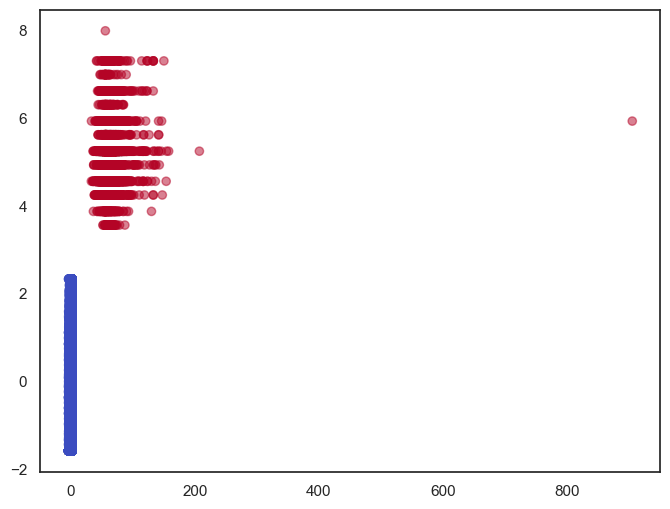

In [46]:
import matplotlib.pyplot as plt
import numpy as np

# Scatterplot of Present_giving (posrecip) vs Personal_retribution (negrecip), colored by gender
plt.figure(figsize=(8,6))
scatter = plt.scatter(df['posrecip'], df['negrecip'], c=df['category_binary'], cmap='coolwarm', alpha=0.5)

# Calculate the line of best fit (abline)
slope, intercept = np.polyfit(df['posreip'], df['negrecip'], 1)
abline_values = slope * df['posrecip'] + intercept

# Plot the abline
plt.plot(df['posrecip'], abline_values, color='black', linestyle='--')

plt.title('Scatterplot of Posrecip (Present_giving) vs Negrecip (Personal_retribution) colored by Gender')
plt.xlabel('Posrecip (Present_giving)')
plt.ylabel('Negrecip (Personal_retribution)')
plt.grid(True)

# Adding a legend for gender
plt.legend(*scatter.legend_elements(), title="Gender")

plt.show()

In [21]:
# Set the dependent and independent variables
df = df.dropna(subset=['Donate', 'age'])
df['age'] = pd.to_numeric(df['age'], errors='coerce')
df['altruism'] = pd.to_numeric(df['altruism'], errors='coerce')
df['trust'] = pd.to_numeric(df['trust'], errors='coerce')


X = df['category_binary']
y = df['gender']

# Add a constant to the independent variable
X = sm.add_constant(X)

# Fit the linear regression model
model = sm.OLS(y, X).fit()

# Print the summary of the regression
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                 gender   R-squared:                      -0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Mon, 23 Sep 2024   Prob (F-statistic):                nan
Time:                        14:36:12   Log-Likelihood:                -4281.4
No. Observations:                5899   AIC:                             8565.
Df Residuals:                    5898   BIC:                             8572.
Df Model:                           0                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
category_binary     0.4999      0.007     


Columns in combined_df:
['participant_id', 'age', 'gender', 'Donate', 'Personal_retribution', 'Present_giving', 'Procrastinate', 'donate_perc', 'donate_q', 'favour_q', 'patience_e', 'patience_q', 'recip_perc', 'retribution_oth_q', 'revenge_q', 'risk_e', 'risk_q', 'subj_math_skills', 'trust', 'patience', 'risktaking', 'posrecip', 'negrecip', 'altruism', 'category', 'ison', 'language', 'wgt', 'country_Algeria', 'country_Argentina', 'country_Australia', 'country_Austria', 'country_Bangladesh', 'country_Bolivia', 'country_Bosnia', 'country_Bosnia_Herzegovina', 'country_Botswana', 'country_Brazil', 'country_Cambodia', 'country_Cameroon', 'country_Canada', 'country_Chile', 'country_China', 'country_Colombia', 'country_Costa_Rica', 'country_Croatia', 'country_Czech_Republic', 'country_Egypt', 'country_Estonia', 'country_Finland', 'country_France', 'country_Georgia', 'country_Germany', 'country_Ghana', 'country_Greece', 'country_Guatemala', 'country_Haiti', 'country_Hungary', 'country_India',

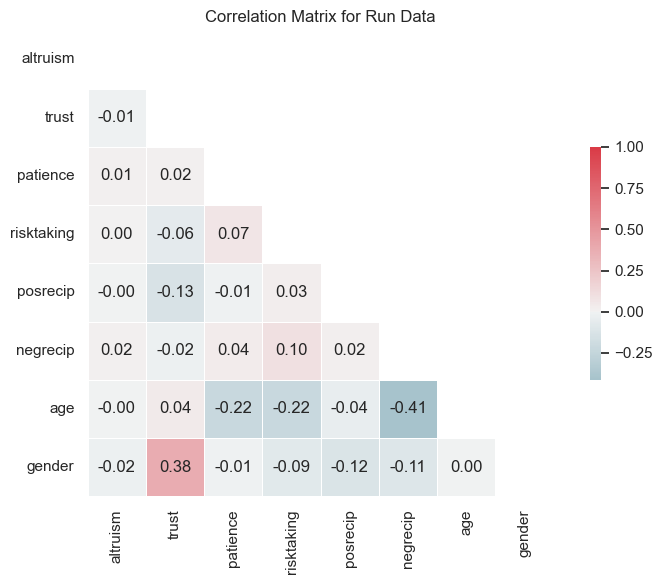

Correlation heatmap saved to /Users/chris/Desktop/run_correlation_matrix.png

Not enough observations to compute correlations for 'Benchmark' category.


In [24]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os

# Suppress warnings for cleaner output (optional)
import warnings
warnings.filterwarnings('ignore')

# ---------------------------
# 1. Load Your Data
# ---------------------------

# Replace the path below with the path to your processed data file
# combined_df = pd.read_csv('/path/to/your/processed_data.csv')

# For demonstration purposes, here's how your DataFrame's columns look:
print("\nColumns in combined_df:")
print(df.columns.tolist())
combined_df = df

# ---------------------------
# 2. Define Variables of Interest
# ---------------------------

variables = ['altruism', 'trust', 'patience', 'risktaking', 'posrecip', 'negrecip', 'age', 'gender']

# Filter for 'run' category
run_data = combined_df[combined_df['category'] == 'run']

# Filter for 'Benchmark' category
benchmark_data = combined_df[combined_df['category'] == 'Benchmark']

# ---------------------------
# 4. Diagnostic Checks for Benchmark Data
# ---------------------------

print(f"\nNumber of observations in 'Benchmark' category: {benchmark_data.shape[0]}")

# Check for missing values
benchmark_missing = benchmark_data[variables].isnull().sum()
print("\nMissing values in Benchmark data:")
print(benchmark_missing)

# Check for standard deviation (variance)
benchmark_std = benchmark_data[variables].std()
print("\nStandard Deviation of variables in Benchmark data:")
print(benchmark_std)

# Check data types
benchmark_dtypes = benchmark_data[variables].dtypes
print("\nData types of variables in Benchmark data:")
print(benchmark_dtypes)

# Convert non-numeric variables to numeric if necessary
# Example for 'trust'
if benchmark_dtypes['trust'] == 'object':
    benchmark_data['trust'] = pd.to_numeric(benchmark_data['trust'], errors='coerce')
    print("\nConverted 'trust' to numeric.")

# Handle missing values
benchmark_data[variables] = benchmark_data[variables].fillna(benchmark_data[variables].mean())
print("\nFilled missing values in Benchmark data with column means.")

# Remove variables with zero variance
zero_variance_vars = benchmark_data[variables].columns[benchmark_data[variables].std() == 0].tolist()
if zero_variance_vars:
    print(f"\nVariables with zero variance in Benchmark data: {zero_variance_vars}")
    variables = [var for var in variables if var not in zero_variance_vars]
    print(f"Updated variables list: {variables}")

# ---------------------------
# 5. Save Processed Data to Desktop
# ---------------------------

# Define the path to save the processed data
desktop_path = os.path.expanduser('~/Desktop/')
output_file = os.path.join(desktop_path, 'processed_data_run_and_benchmark.csv')

# Save the filtered run and Benchmark data to Desktop
combined_df.to_csv(output_file, index=False)
print(f"\nProcessed data saved to {output_file}")

# ---------------------------
# 6. Generate Correlation Matrices
# ---------------------------

# Function to compute and plot correlation matrix
def compute_and_plot_corr(data, category_name, variables, desktop_path):
    # Check if there are enough observations
    if data.shape[0] < 2:
        print(f"\nNot enough observations to compute correlations for '{category_name}' category.")
        return
    
    # Compute correlation matrix
    corr_matrix = data[variables].corr()
    
    # Check if all values are NaN
    if corr_matrix.isnull().all().all():
        print(f"\nAll correlation coefficients are NaN for '{category_name}' category.")
        return
    
    # Display correlation matrix
    print(f"\nCorrelation Matrix for {category_name} Data:")
    print(corr_matrix)
    
    # Plot heatmap
    plt.figure(figsize=(8, 6))
    sns.set(style='white')
    
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    
    sns.heatmap(corr_matrix, mask=mask, cmap=cmap, vmax=1.0, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, fmt=".2f")
    
    plt.title(f'Correlation Matrix for {category_name} Data')
    plt.tight_layout()
    
    # Save the heatmap
    heatmap_file = os.path.join(desktop_path, f'{category_name.lower()}_correlation_matrix.png')
    plt.savefig(heatmap_file)
    plt.show()
    print(f"Correlation heatmap saved to {heatmap_file}")

# Compute and plot correlation for 'run' data
compute_and_plot_corr(run_data, 'Run', variables, desktop_path)

# Compute and plot correlation for 'Benchmark' data
compute_and_plot_corr(benchmark_data, 'Benchmark', variables, desktop_path)